# Exercise 1.5.1 - Non-Maximum Suppression
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered by Udacity.

## Objectives

* Implement the Non-Maximum Suppression ([NMS](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/)) algorithm;
* Use the Intersection over Union ([IoU](https://en.wikipedia.org/wiki/Jaccard_index)) metric with a threshold value of $0.7$; 
* Apply the NMS algorithm to the provided frame from the [Waymo Open Dataset](https://waymo.com/open/);
* (Optional) Use the [Soft-NMS](https://arxiv.org/abs/1704.04503) algorithm to re-score the bounding box predictions.

## 1. Introduction

In [1]:
### Importing the required modules

In [2]:
import json
import numpy as np
import os
import matplotlib as mpl
from matplotlib import colors, patches
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from typing import List, Union

In [3]:
tf.__version__

'2.4.0'

In [4]:
tf.test.gpu_device_name()

2022-09-25 11:52:22.920530: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

In [5]:
### Setting the environment variables

In [6]:
ENV_COLAB = False                # True if running in Google Colab instance

In [7]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [8]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [9]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Non-Maximum Suppression

#### Background
* Why is it used?
* How is it implemented?
* What are the drawbacks?

[Non-maximum suppression](https://paperswithcode.com/method/non-maximum-suppression) (NMS) [1] is a popular technique used in object detection pipelines for handling duplicate or redundant bounding box predictions. Since object detection algorithms tend to produce more than one candidate bounding boxes for a single object, NMS is used to preserve only the _best_ bounding box per object using a overlap score. 

#### History

Traditional object detection algorithms used an _exhaustive search_ method; by iteratively spanning the entire image space, any and all objects could in theory be precisely located. While this sliding window approach was successful in detecting objects at all sorts of unpredictable locations, exhaustive search was an extremely expensive algorithm to run — exploring and eliminating tens of thousands of candidate regions per image was far from efficient. Exhaustive search and other sliding window-based algorithms quickly became a relic and were replaced with more intuitive algorithms for object detection.

Modern deep learning detection algorithms use a _region-based_ "approximation" algorithm to obtain object locations. Rather than scanning the entire image space iteratively, the image is split into sub-regions and analysed more efficiently using convolutional feature maps to determine whether or not an object is present. The [region-based convolutional neural networks](https://en.wikipedia.org/wiki/Region_Based_Convolutional_Neural_Networks) family, known as R-CNNs, revolutionised object detection and helped speed up efficiency to allow for real-time detection needed in today's applications of self-driving car technology. 

With these new methods brought a new set of challenges; R-CNN architectures often produced many candidate bounding boxes for each object detected. In order to eliminate the redundant boxes and preserve only one candidate bounding box per object, a new "post-processing" step needed to be defined. In 2009, Felzenszwalb et al., created _non-maxima suppression_ (NMS), a scoring metric that combined the [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) and the predicted _confidence score_ into a single metric. NMS effectively discarded all but one bounding box for each object, eliminating the redundant bounding box problem.

### 1.2. Soft-NMS

Researchers began to notice that non-maximum suppression wasn't perfect; NMS tended to disregard otherwise valid objects of interest. These objects in particular were _occluded_ (obstructed or "blocked" by another object). Such objects have bound to have confidence scores that are lower than the average, thus a fixed threshold wouldn't cut it.

Simply decreasing the confidence threshold to account for this could lead to a drop in average precision, increasing the number of _false positives_ ("other" bounding boxes belonging to the same object). Consequently, when the overlap threshold is increased, valid bounding boxes can be unintentionally suppressed (discarded), leaving some objects without a corresponding bounding box. This is especially relevant in the driving environment. As in high-density traffic conditions; two separate cars might share a high-degree of overlap. As a result, only one of the two overlapping bounding boxes would be preserved (the one with the greatest confidence threshold). In other words, both cars would be incorrectly assigned to the same bounding box.

Soft-NMS by Bodla et al., seeks to address this problem in their cleverly-titled paper "Improving Object Detection With One Line of Code" [2]. Rather than suppressing boxes with a high-degree of overlap, we can instead decrease ("decay") their classification score. Re-running those candidates through a thresholding function could have one of two effects: those candidates no longer meet the threshold requirement and are therefore dropped, or, they are above the threshold and can therefore be kept. While the separate cars scenario might benefit from this simple case, as both boxes would be preserved, the more trivial case might be that the neighbouring redundant bounding box candidates would be incorrectly kept as well. Because of this likely scenario, Bodla et al. proposed a decay function that decreased the confidence scores linearly proportional to overlap amount. Therefore, candidate boxes that had a very high degree of overlap would experience a larger decay (greater penalty) than neighbouring bounding boxes without as much overlap. To better account for false positives, the Gaussian penalty function was introduced. By applying the update rule in each iteration, boxes with the highest degree of overlap are pruned and the number of false positives reduced at each step.

## 2. Programming Task

### 2.1. Non-Maximum Suppression

You are given a json file containing a list of predictions, containing `boxes` and `scores`.

You will leverage the `calculate_iou` function to calculate the Intersection Over Union (IoU) of these different predictions and implement the NMS algorithm.

#### IoU algorithm in Python

In [10]:
### From Udacity's `utils.py`

In [11]:
def calculate_iou(
        bboxes1: tf.Tensor, 
        bboxes2: tf.Tensor
) -> tf.Tensor:
    """Calculates the IoU score between a batch of bounding boxes.
    
    It is assumed that the number of bounding boxes N and M in each batch
    are equal. It is also assumed that the coordinates are ordered as follows:
        bbox := [y1, x1, y2, x2].
    
    :param bboxes1: the Nx4 bounding box coordinates.
    :param bboxes2: the Mx4 bounding box coordinates.
    :returns: iou, the intersection over union (IoU) scores between
        the two batches of bounding boxes.
    """
    
    ### 1. Get the upper and lower (y, x) coordinate pairs
    ymins = tf.math.maximum(bboxes1[..., 0], bboxes2[..., 0])
    xmins = tf.math.maximum(bboxes1[..., 1], bboxes2[..., 1])
    ymaxs = tf.math.minimum(bboxes1[..., 2], bboxes2[..., 2])
    xmaxs = tf.math.minimum(bboxes1[..., 3], bboxes2[..., 3])
    ### 2. Compute the following:
    # Area of the intersection
    intersections = tf.math.maximum(0, ymaxs - ymins) * tf.math.maximum(0, xmaxs - xmins)
    # Area of the first batch
    heights = bboxes1[..., 2] - bboxes1[..., 0]
    widths = bboxes1[..., 3] - bboxes1[..., 1]
    bboxes1_areas = heights * widths
    # Area of the second batch
    heights = bboxes2[..., 2] - bboxes2[..., 0]
    widths = bboxes2[..., 3] - bboxes2[..., 1]
    bboxes2_areas = heights * widths
    # Area of the union
    unions = tf.cast(bboxes1_areas + bboxes2_areas - intersections, tf.dtypes.float32)
    ### 3. Return the IoU scores
    iou = tf.cast(intersections, tf.dtypes.float32) / (unions + 1e-16)
    return tf.squeeze(iou)

To do so, you will need to:
* compare each bounding box with all the other bounding boxes in the set
* for each pair of bounding boxes, calculate the IoU and compare the scores
* if the IoU is above the threshold, keep the box with the highest score

#### NMS algorithm in Python

In [12]:
### From Udacity's `nms.py`

In [13]:
def nms(
        predictions: dict, 
        confidence_threshold: float=0.7, 
        iou_threshold: float=0.5
) -> List[Union[List[int], float]]:
    """Performs non-maximum suppression (Felzenszwalb et al., 2008).
    
    Credit: https://bit.ly/3xQeFom
    
    :param predictions: the dict instance containing the ground truth
        and predicted bounding box coordinates.
    :param confidence_threshold: float, the confidence threshold, any
        bounding box with score above this threshold is preserved.
    :param iou_threshold: float, intersection over union threshold, any
        bounding box with IoU score above this threshold is suppressed.
    :returns filtered: the nested list of thresholded bounding box coordinates
        and their corresponding confidence scores.
    """
    
    filtered = []
    # IMPLEMENT THIS FUNCTION
    
    ### 1. Discard all predictions below confidence threshold
    # Getting indices of bounding boxes w.r.t. confidence in descending order
    idxs = tf.argsort(predictions['scores'], direction='DESCENDING')
    # Sorting the bounding boxes and their scores
    scores = tf.gather(tf.cast(predictions['scores'], tf.dtypes.float32), idxs)
    bboxes = tf.gather(predictions['boxes'], idxs)
    # Keeping only the bounding boxes above the threshold
    bboxes = bboxes[scores > confidence_threshold]
    ### 2. For any remaining boxes
    while len(bboxes) >= 2:
        # Keep the bounding box with highest confidence score
        filtered.append([
            tf.squeeze(bboxes[0, :]).numpy().tolist(), tf.squeeze(scores[0]).numpy()])
        # Update the remaining bounding boxes and their scores
        other = bboxes[1:, :]
        scores = scores[1:]
        ### 3. Compute IoU scores between the bbox and all `m` other bboxes
        # `broadcast_to` repeats the bbox coordinates `m` times
        iou_scores = calculate_iou(
                        bboxes1=tf.broadcast_to(bboxes[0, :], other.shape),
                        bboxes2=other
        )
        # Keep bboxes whose IoU score is less than threshold
        idxs_keep = tf.where(iou_scores < iou_threshold)
        bboxes = tf.gather(other, idxs_keep)
        scores = tf.gather(scores, idxs_keep)
    return filtered

You can run `python nms.py` to check your implementation.

#### Testing the NMS algorithm

In [15]:
### From Udacity's `nms.py`

In [16]:
### Fetching the predicted data
with open('data/predictions_nms.json', 'r') as f:
    predictions = json.load(f)

In [17]:
predictions = tf.data.Dataset.from_tensors(predictions)

In [18]:
### Obtaining the 'picked' bounding boxes after performing NMS
output = nms(iter(predictions).get_next(), confidence_threshold=0.0, iou_threshold=0.5)
output

[[[107, 107, 192, 148], 0.8147568]]

#### Evaluating our results

In [19]:
### From Udacity's `utils.py`

In [20]:
def check_results(output):
    truth = np.load(os.path.join(DIR_SRC, 'nms.npy'), allow_pickle=True)
    assert np.array_equal(truth, np.array(output, dtype="object")), 'The NMS implementation is wrong'
    print('The NMS implementation is correct!')

In [ ]:
### Checking our results against Udacity's
with open(os.path.join(DIR_SRC, 'predictions_nms.json')) as f:
    preds_nms = json.load(f)
    preds_nms = tf.data.Dataset.from_tensors(preds_nms)
    check_results(nms(iter(preds_nms).get_next(), confidence_threshold=0.0, iou_threshold=0.5))

### 2.2. Soft-NMS

#### Soft-NMS algorithm in Python

In [84]:
def soft_nms(
        predictions: dict, 
        confidence_threshold: float=1e-3, 
        iou_threshold: float=0.3,
        method: str=None,
        sigma: float=0.5
) -> List[Union[List[int], float]]:
    """Soft-NMS algorithm (Bodla et al., 2017).
    
    :param predictions: the dict instance containing the ground truth
        and predicted bounding box coordinates.
    :returns filtered: the list of thresholded bounding boxes and their
        computed Soft-NMS scores.
    """
    
    filtered = []
    # IMPLEMENT THIS FUNCTION
    
    ### 1. Discard all predictions below confidence threshold
    # Getting indices of bounding boxes w.r.t. confidence in descending order
    idxs = tf.argsort(predictions['scores'], direction='DESCENDING')
    # Sorting the bounding boxes and their scores
    scores = tf.gather(tf.cast(predictions['scores'], tf.dtypes.float32), idxs)
    bboxes = tf.gather(predictions['boxes'], idxs)
    # Keeping only the bounding boxes above the threshold
    bboxes = bboxes[scores > confidence_threshold]
    ### 2. For any remaining boxes
    while bboxes.shape[0] > 2:
        # Keep the bounding box with highest confidence score
        this = tf.squeeze(bboxes[0, :])
        filtered.append([this.numpy().tolist(), tf.squeeze(scores[0]).numpy()])
        # Update the remaining bounding boxes and their scores
        other = tf.squeeze(bboxes[1:, :])
        scores = scores[1:]
        ### 3. Compute IoU scores between the bbox and all `m` other bboxes
        # `broadcast_to` repeats the bbox coordinates `m` times
        iou_scores = calculate_iou(
                        bboxes1=tf.broadcast_to(this, other.shape),
                        bboxes2=other
        )
        ### 4. Soft-NMS: Re-scoring the IoU scores with weighting
        # Get indices of IoU scores to weight / keep same
        idxs_weight = tf.where(iou_scores >= iou_threshold)
        idxs_same = tf.where(iou_scores < iou_threshold)
        # Create sparse tensors to allow for weight value manipulation
        vals_weight = tf.sparse.SparseTensor(indices=idxs_weight, 
                                             values=tf.squeeze(tf.ones_like(idxs_weight, tf.float32)),
                                             dense_shape=iou_scores.shape
        )
        vals_same = tf.sparse.SparseTensor(indices=idxs_same,
                                           values=tf.squeeze(tf.ones_like(idxs_same, tf.float32)),
                                           dense_shape=iou_scores.shape
        )
        if method == 'linear':
            vals_weight = tf.sparse.map_values(tf.add, vals_weight, 
                                               -tf.gather(iou_scores, idxs_weight))
        elif method == 'gaussian':
            vals_weight = tf.sparse.map_values(tf.multiply, vals_weight,
                                               tf.math.exp(-(iou_scores ** 2)) / sigma)
        else:
            # No re-scoring, use original NMS strategy
            vals_weight = tf.sparse.map_values(tf.add, vals_weight, -1.0)
        # Convert sparse weight vectors to dense-valued tensors
        weight = tf.sparse.add(vals_weight, vals_same)
        weight = tf.sparse.to_dense(weight)
        # Update the IoU scores with the calculated weight values
        iou_scores *= weight
        # Keep bboxes whose weighted IoU score is less than threshold
        idxs_keep = tf.where(iou_scores > confidence_threshold)
        bboxes = tf.squeeze(tf.gather(other, idxs_keep))
        scores = tf.gather(scores, idxs_keep)
    return filtered

In [20]:
### Fetching the predicted data
with open('data/predictions_nms.json', 'r') as f:
    predictions = json.load(f)

In [21]:
predictions = tf.data.Dataset.from_tensors(predictions)

In [22]:
bboxes = predictions.map(lambda x: x['boxes'])

In [23]:
first = bboxes.map(lambda x: x[:1])
others = bboxes.map(lambda x: x[1:])

In [24]:
iou_scores = calculate_iou(
    bboxes1=tf.broadcast_to(iter(first).get_next(), iter(others).get_next().shape),
    bboxes2=iter(others).get_next()
)
iou_scores

2022-09-25 11:52:39.470067: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.58529294, 0.793604  , 0.88151413, 0.7442517 , 0.5953283 ,
       0.546411  , 0.735196  , 0.49844033], dtype=float32)>

#### Testing the Soft-NMS algorithm

In [25]:
### Fetching the predicted data
with open('data/predictions_nms.json', 'r') as f:
    predictions = json.load(f)

In [26]:
predictions = tf.data.Dataset.from_tensors(predictions)
predictions

<TensorDataset shapes: {classes: (9,), boxes: (9, 4), scores: (9,)}, types: {classes: tf.int32, boxes: tf.int32, scores: tf.float32}>

In [27]:
### Obtaining the 'picked' bounding boxes after performing regular NMS
output_nms = soft_nms(iter(predictions).get_next(), confidence_threshold=0.0, iou_threshold=0.3,
                      method=None
)
output_nms

[[[107, 107, 192, 148], 0.8147568]]

In [28]:
### Obtaining the 'picked' bounding boxes after performing soft-NMS
output_snms = soft_nms(iter(predictions).get_next(), confidence_threshold=0.00001, iou_threshold=0.3,
                       method='gaussian', sigma=0.5
)
output_snms

[[[107, 107, 192, 148], 0.8147568],
 [[101, 90, 206, 141], 0.7962376],
 [[101, 103, 192, 153], 0.60673374],
 [[106, 94, 195, 141], 0.6034416],
 [[102, 91, 198, 157], 0.4747843],
 [[104, 102, 196, 155], 0.12201349],
 [[106, 108, 198, 149], 0.074098885]]

#### Visualising the results

In [29]:
### Fetching the ground-truth bounding boxes
with open(os.path.join(DIR_SRC, 'ground_truths.json'), 'r') as f:
    ground_truth = json.load(f)
ground_truth

[{'boxes': [[793, 1134, 1001, 1718],
   [737, 0, 898, 260],
   [763, 484, 878, 619],
   [734, 0, 1114, 277],
   [820, 1566, 974, 1914],
   [762, 951, 844, 1175],
   [748, 197, 803, 363]],
  'classes': [1, 1, 1, 1, 1, 1, 1],
  'filename': 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'}]

In [30]:
### From J. Moran's `2022-08-01-Data-Acquisition-Visualisation.ipynb`

In [35]:
def bbox_to_rectangle(bbox: List[int], **params) -> mpl.patches.Rectangle:
    """Renders bounding boxes as Matplotlib patches.
    
    Bounding box coordinate pairs form a single 
    orthogonal rectangle about the x-y plane.
    The upper-left coordinates are given by (y1, x1)
    and the lower-left coordinates by (y2, x2).
    
    Note that this assumes a bounding box coordinate ordering of:
        bbox := [y1, x1, y2, x2].
    
    :param bbox: list of bounding box coordinates
    :param **params: dict-like object of `matplotlib.patches.Rectangle`
        parameters, e.g., `linewidth`, `color`, and `linestyle`.
    :returns: matplotlib Rectangle patch instance
    """
    
    return patches.Rectangle(xy=(bbox[1], bbox[0]), 
                             width=(bbox[3]-bbox[1]), height=(bbox[2]-bbox[0]), 
                             **params)

In [36]:
# Bounding box colours
class_colourmap = {1:'cyan',        # Ground-truth 
                   2:'magenta',     # NMS picked
                   3:'yellow'}      # Soft-NMS picked
default = 'red'

In [37]:
# Rectangle patch parameters
rect_params = {'fill': False,
               'edgecolor': default,
               'linewidth': 2,
               'linestyle': '--'
              }

In [85]:
### Fetching the test image filename
test_image = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'

In [86]:
### Fetching the predicted data
with open('data/predictions.json', 'r') as f:
    predictions = json.load(f)
predictions

[{'boxes': [[783, 1104, 1011, 1700],
   [717, 0, 908, 280],
   [734, 0, 1100, 240],
   [744, 0, 1080, 258],
   [753, 474, 868, 609],
   [830, 1500, 1004, 1914],
   [758, 192, 811, 364],
   [810, 1576, 973, 1909]],
  'classes': [1, 1, 1, 2, 1, 1, 1, 3],
  'scores': [0.32, 0.97, 0.51, 0.44, 0.12, 0.99, 0.73, 0.95],
  'filename': 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'}]

In [87]:
predictions = tf.data.Dataset.from_tensors(predictions[0])
predictions

<TensorDataset shapes: {boxes: (8, 4), classes: (8,), scores: (8,), filename: ()}, types: {boxes: tf.int32, classes: tf.int32, scores: tf.float32, filename: tf.string}>

In [88]:
### Obtaining the 'picked' bounding boxes after performing soft-NMS
output_snms = soft_nms(iter(predictions).get_next(), confidence_threshold=0.001, iou_threshold=0.8,
                       method='gaussian', sigma=0.5
)
output_snms

InvalidArgumentError: Incompatible shapes: [0] vs. [7] [Op:Mul]

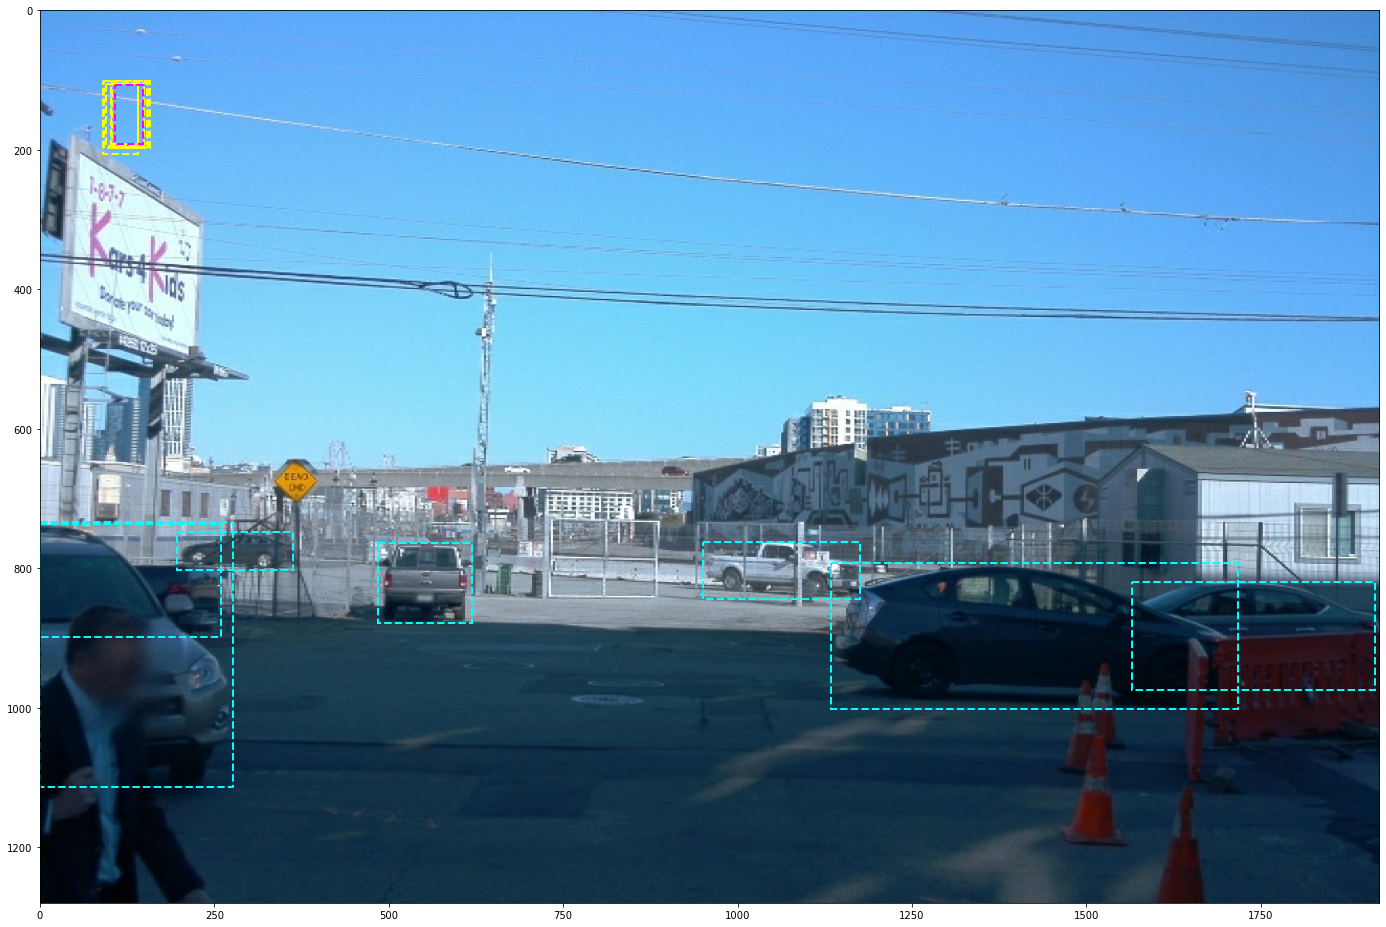

In [34]:
fig = plt.figure(figsize=(24,24))
image = Image.open(os.path.join(DIR_SRC, test_image))
ax = fig.add_subplot(111)
ax.imshow(image)

### Plot the ground-truth bounding boxes
for j, bbox in enumerate(ground_truth[0]['boxes']):
    # Get bounding box class
    cls_bbox = ground_truth[0]['classes'][j]
    # Update bbox color
    rect_params['edgecolor'] = class_colourmap.get(cls_bbox, 'red')
    ax.add_patch(bbox_to_rectangle(bbox, **rect_params))
### Plot the picked bounding boxes preserved with Soft-NMS
for j, bbox in enumerate(output_snms):
    # Here we assume all bboxes are of same class;
    # instead use colour to indicate ground truth/NMS/Soft-NMS
    cls_bbox = 3
    # Update bbox color
    rect_params['edgecolor'] = class_colourmap.get(cls_bbox, 'red')
    ax.add_patch(bbox_to_rectangle(bbox[0], **rect_params))
### Plot the picked bounding boxes preserved with NMS
for j, bbox in enumerate(output_nms):
    # Here we assume all bboxes are of same class;
    # instead use colour to indicate ground truth/NMS/Soft-NMS
    cls_bbox = 2
    # Update bbox color
    rect_params['edgecolor'] = class_colourmap.get(cls_bbox, 'red')
    ax.add_patch(bbox_to_rectangle(bbox[0], **rect_params))
ax.imshow(image)
plt.show()

**UPDATE 2022-09-24**: So we can see from the resulting yellow and magenta boxes (the 'picked' NMS and soft-NMS results), we were able to preserve one additional bounding box for the right-most vehicle in the above scene. Note that the magenta NMS bounding box exactly overlaps one of the yellow soft-NMS bounding boxes.

The Soft-NMS strategy could be beneficial for tracking the over-lapping vehicle whose bounding box with the regular NMS strategy was ignored.

## 3. Closing Remarks

##### Alternatives
* Use the [Soft-NMS](https://arxiv.org/abs/1704.04503) algorithm to handle occluded objects;
* Use the built-in NMS and soft-NMS functions: [`tf.image.non_max_suppression()`](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression) and [`tf.image.non_max_suppression_with_scores()`](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression_with_scores).

##### Extensions of task
* Apply NMS to a object detection pipeline.

## 4. Future Work

- [x] Compare NMS and Soft-NMS on images with occluded objects;
- [ ] Add NMS/Soft-NMS to an object detection pipeline.

## Credits

This assignment was prepared by Thomas Hossler et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).


References

[1] Felzenszwalb, P. F., et al. Object Detection with Discriminatively Trained Part-Based Models. IEEE Transactions on Pattern Analysis and Machine Intelligence. 32(9):1627-1645. 2010. [doi:10.1109/TPAMI.2009.167](https://ieeexplore.ieee.org/document/5255236).

[2] Bodla, N. et al. Soft-NMS — Improving Object Detection With One Line of Code. arXiv. 2017. [doi:10.48550/ARXIV.1704.04503](https://arxiv.org/abs/1704.04503).



Further reading:
* Uijlings, J.R.R., et al. Selective Search for Object Recognition. International Journal of Computer Vision, 104:154–171. 2013. [doi:10.1007/s11263-013-0620-5](https://doi.org/10.1007/s11263-013-0620-5).

* Ren, S., et al., Faster R-CNN: Towards real-time object detection with region proposal networks. Advances in Neural Information Processing Systems, vol. 28. 2015. [doi:10.48550/ARXIV.1506.01497](https://arxiv.org/abs/1506.01497).



Helpful resources:
* [Selective Search for Object Recognition by S. Smith | CS231B at Stanford University](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ssearch_schuyler.pdf)